# Tutorial 7 - tf.data and autoencoders

In this tutorial, you will use the tf.data functions to create a tensorflow dataset. You will then construct an autoencoder model, and use the dataset as the training input to the model. Finally, you will explore the properties of the model, in relation to the image labels.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1

Begin by loading the fashion MNIST dataset. Create a function called "preprocessing" that takes in an image, and performs the following steps:


1.   Add a channels axis to the image
2.   Randomly applies a left/right flip to the image
3.   Converts the image to `dtype='float32'`
4.   IMPORTANT: returns the same image TWICE

Use the `.from_tensor_slices` function to create a dataset from the training images. Use dataset methods to shuffle the images, batch them and then apply the preprocessing function.

Check the output of the dataset. It should return a tuple with 2 entries, each containing a batch of images with shapes:

`(batch_size, 28, 28, 1)`

In [ ]:
### Load the fashion mnist dataset from keras.datasets

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
### Create the preprocessing function, as described
# tf.expand_dims/tf.reshape, tf.image.random_flip_left_right,
# tf.image.convert_image_dtype

def preprocessing(image):
    """
    An image preprocessing function to prepare data for the autoencoder

    Arguments:
        image (tf.Tensor) — uint8 datatype, shape (height, width)

    Performs the following transformations:
        Add a channels axis to the image
        Randomly applies a left/right flip to the image
        Converts the image to `dtype='float32'`
        IMPORTANT: returns the same image TWICE

    """

    image = tf.expand_dims(image, -1)
    image = tf.image.random_flip_left_right(image)
    image  = tf.image.convert_image_dtype(image, 'float32')

    return image, image

In [ ]:
### Create a dataset using the training images
# tf.data.Dataset.from_tensor_slices

FM_dataset = tf.data.Dataset.from_tensor_slices(x_train)

In [ ]:
### Prepare the dataset for training
# .shuffle, .batch, .map

PreProc_dataset = FM_dataset.shuffle(1000).batch(32, drop_remainder=True).map(preprocessing)

# Exercise 2

Using the functional model API, construct the autoencoder.

Starting with the encoder model, with the layers:
```
enc_in, Input, shape=(28,28,1), dtype='float32'
flat, Flatten
dense_1, Dense, 256 units, 'relu' activation
encoded, Dense, 2 units, no activation
```

The decoder model should have the layers:
```
dec_in, Input, shape=(2,), dtype='float32'
dense_2, Dense, units=256, activation='relu'
dense_3, Dense, units=784, activation='relu'
decoded, Reshape, shape=(28,28,1), no activation
```

To assemble the autoencoder, use the encoder input layer as the model inputs. To get the outputs, you need to nest calls of the encoder and decoder, like so:
```
decoder(encoder(enc_in))
```

Print the summaries of all three models.

In [ ]:
from tensorflow.keras import layers, models, losses, metrics, optimizers

In [ ]:
### Define Encoder model
# layers.Input, layers.Flatten, layers.Dense, models.Model, .summary
# Functional model means to call a layer with a tensor:
# Layer(layer arguments)(tensor)

enc_in = layers.Input(shape=(28,28,1), dtype='float32')
flat = layers.Flatten()(enc_in)
D1 = layers.Dense(256, activation='relu', name='dense_1')(flat)
latent = layers.Dense(2, name='latents')(D1)

encoder = models.Model(inputs = enc_in, outputs = latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               200960    
                                                                 
 latents (Dense)             (None, 2)                 514       
                                                                 
Total params: 201,474
Trainable params: 201,474
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### Define Decoder Model
# layers.Input, layers.Dense, layers.Reshape, models.Model, .summary

dec_in = layers.Input(shape=(2,), dtype='float32')
D2 = layers.Dense(256, activation='relu', name='dense_2')(dec_in)
D3 = layers.Dense(784, activation='relu', name='dense_3')(D2)
img_out = layers.Reshape((28,28,1), name='img_out')(D3)

decoder = models.Model(inputs = dec_in, outputs=img_out, name='decoder')

In [ ]:
### Define Autoencoder Model
# inputs = enc_in, outputs = decoder(encoder(enc_in))
# models.Model, .summary

autoencoder = models.Model(inputs = enc_in, outputs = decoder(encoder(enc_in)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 201474    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         202256    
                                                                 
Total params: 403,730
Trainable params: 403,730
Non-trainable params: 0
_________________________________________________________________


# Exercise 3

Compile the autoencoder model with the Adam optimizer and Mean Squared Error loss. Fit the model using your dataset as the input, for 25 epochs.

In [ ]:
### Compile the model with the Adam optimizer and mean squared error loss
autoencoder.compile(optimizer='Adam', loss='mse')

In [ ]:
### Fit the model for 25 epochs, using the preprocessed dataset as input
autoencoder.fit(PreProc_dataset, epochs=25)

Epoch 1/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0595
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0505
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0475
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0455
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0429
Epoch 6/25
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0410
Epoch 7/25
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0405
Epoch 8/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0398
Epoch 9/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0394
Epoch 10/25
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0391
Epoch 11/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0387
Epoch 12/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0381


# Exercise 4

Use the test images with the `.predict` method of the autoencoder model—don't forget to scale the pixel ranges—to generate the image reconstructions. Create a plot that compares the original test images and the reconstructions—for an extra challenge, plot a sample of images from each of the 10 classes with their reconstructions.

The encoder model compresses the images into a 2-D "latent space". Call the encoder, using the test images as input, to produce encoded vectors of each image. Plot these encodings on a scatter plot, using the image labels as the colour for the markers.

In [ ]:
### Predict the reconstructed images for the test images
# .predict
x_pred = autoencoder.predict(x_test/255.)

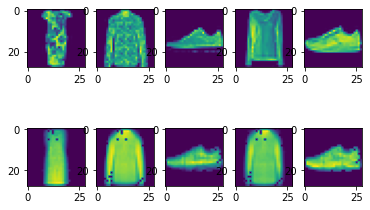

In [ ]:
### Create a plot that compares the original test images and the reconstructions
### For an extra challenge, plot a sample of images from each of the 10 classes
### with their reconstructions.

f, ax = plt.subplots(2, 5)

for i in range(5):
    ax[0,i].imshow(x_test[i+100])
    ax[1,i].imshow(x_pred[i+100,:,:,0])

In [ ]:
### Encoder the test images by calling the encoder model with the images as an
### argument

z_pred = encoder(x_test/255.)

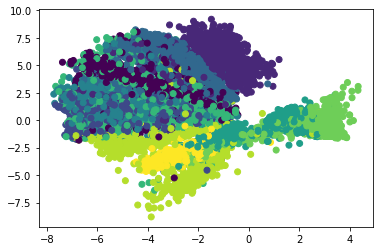

In [ ]:
### Create a scatter plot of the encoded images, using the image labels as the
### marker colours

plt.scatter(z_pred[:,0], z_pred[:,1], c=y_test)

# Exercise 5

Save your model using the `.save` method. Reload the model, using a different variable name, using `models.load_model`. Test that the loaded model works by repeating the steps to create the plotted images and reconstructions, above.

In [ ]:
### Save the model.
# .save

autoencoder.save('Autoencoder_model')

INFO:tensorflow:Assets written to: Autoencoder_model/assets


In [ ]:
### Reload the model, use a different variable name
# models.load_model

autoencoder2 = models.load_model('Autoencoder_model')

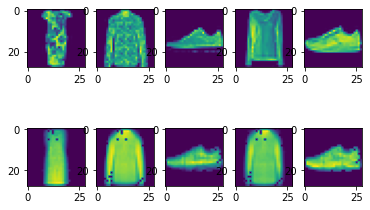

In [ ]:
### Repeat the steps to produce the comparison plot of the test images and
### reconstructions, using the loaded model to predict the reconstructions

x_pred = autoencoder2.predict(x_test/255.)

f, ax = plt.subplots(2, 5)

for i in range(5):
    ax[0,i].imshow(x_test[i+100])
    ax[1,i].imshow(x_pred[i+100,:,:,0])